# Classification of Dementia - Supervised Learning Project

In [1]:
# Load packages:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

## Data Summary

In this classification project, I am using demographics data from the [Oasis Study](https://www.oasis-brains.org/) to predict a diagnosis of dementia:  
* *OASIS, Longitudinal: Principal Investigators: D. Marcus, R, Buckner, J. Csernansky, J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382*    
* [Marcus, DS, Fotenos, AF, Csernansky, JG, Morris, JC, Buckner, RL, 2010. Journal of Cognitive Neuroscience, 22, 2677-2684. doi: 10.1162/jocn.2009.21407](https://www.mitpressjournals.org/doi/full/10.1162/jocn.2009.21407)  

This dataset contains longitudinal data for 150 adults age 60 to 96. The target varible is whether the individual has dementia or not ('Group'). Other relevant features include:  
* Gender (M/F)  
* Age   
* Years of Education (EDUC)  
* Socioeconomic status (SES)  
* Mini Mental State Examination (MMSE)  
* Clinical Dementia Rating (CDR)  
* Normalized Whole Brain Volume (nWBV)  

Note that the data contains > 1 visit per subject, but I am just analzing data for the first visit here.  

In [2]:
data = pd.read_csv('oasis_longitudinal.csv')
data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


Check for any duplicates:

In [3]:
data.duplicated().sum()

0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [5]:
data.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


### Clean and visualize data:  

Replace any rows with NAs with median/mean:

In [6]:
data.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [7]:
data["SES"].fillna(data["SES"].median(), inplace=True)
data["MMSE"].fillna(data["MMSE"].mean(), inplace=True)

Drop unsused variables:

In [8]:
data.drop(columns=['Hand','MR Delay','eTIV','ASF', 'MRI ID'], inplace = True)
data.head()

,Subject ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,nWBV
0,OAS2_0001,Nondemented,1,M,87,14,2.0,27.0,0.0,0.696
1,OAS2_0001,Nondemented,2,M,88,14,2.0,30.0,0.0,0.681
2,OAS2_0002,Demented,1,M,75,12,2.0,23.0,0.5,0.736
3,OAS2_0002,Demented,2,M,76,12,2.0,28.0,0.5,0.713
4,OAS2_0002,Demented,3,M,80,12,2.0,22.0,0.5,0.701


How many unique subjects are there?

In [9]:
nsubs = len(data['Subject ID'].unique())
print('\nFound ' + str(nsubs) + ' subjects over a total of ' + str(data.shape[0]) + ' visits\n')


Found 150 subjects over a total of 373 visits



Given that subjects have multiple visits, I'm just going to analyze the first visit for now:

In [10]:
data_1 = data[data['Visit'] == 1].copy().reset_index(drop=True)
data_1.drop(columns='Visit', inplace=True)
data_1.shape

(150, 9)

How many subjects per group, and how many are male/female?

In [11]:
data_1[['Group', 'M/F']].value_counts().to_frame().reset_index()

,Group,M/F,0
0,Nondemented,F,50
1,Demented,M,36
2,Demented,F,28
3,Nondemented,M,22
4,Converted,F,10
5,Converted,M,4


Move converted to demented group:

In [12]:
data_1['Group'].replace(['Converted'], ['Demented'], inplace=True)

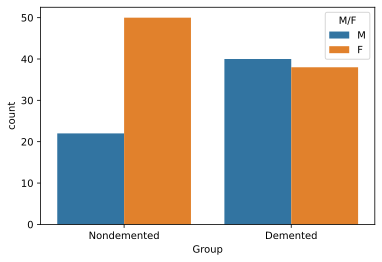

In [13]:
# plot:
sns.countplot(data=data_1, x='Group', hue= 'M/F')
plt.show()

Relationships between all of my numeric variables:

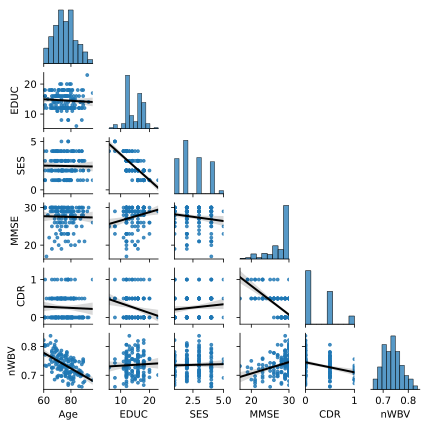

In [14]:
sns.pairplot(data_1.select_dtypes(exclude="object"), 
             kind="reg", height=1, corner=True,
             plot_kws={'scatter_kws':{'s':8},
                       'line_kws':{'color':'black',
                                   'lw':2}})
plt.show()

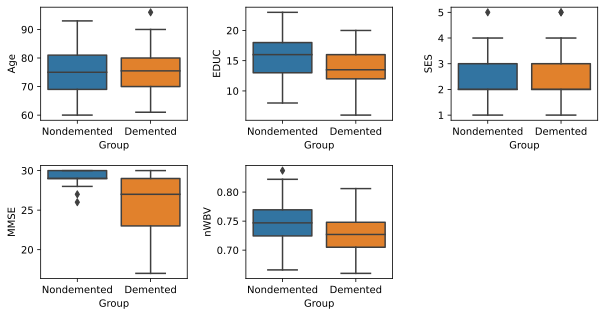

In [15]:
# Summarise continuous features per group
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(2,3,1)
sns.boxplot(data=data_1, x='Group', y='Age', ax=ax1)
ax1=fig.add_subplot(2,3,2)
sns.boxplot(data=data_1, x='Group', y='EDUC', ax=ax1)
ax1=fig.add_subplot(2,3,3)
sns.boxplot(data=data_1, x='Group', y='SES', ax=ax1)
ax1=fig.add_subplot(2,3,4)
sns.boxplot(data=data_1, x='Group', y='MMSE', ax=ax1)
ax1=fig.add_subplot(2,3,5)
sns.boxplot(data=data_1, x='Group', y='nWBV', ax=ax1)

plt.subplots_adjust(hspace=0.4,
                    wspace=0.4)
plt.show()

Finally, I'll need to encode my categorical features for modelling:

In [16]:
data_1['Group'] = data_1['Group'].map({"Demented": 1, "Nondemented": 0})
data_1['M/F'] = data_1['M/F'].map({'F': 0, 'M': 1})

In [17]:
data_1.head()

,Subject ID,Group,M/F,Age,EDUC,SES,MMSE,CDR,nWBV
0,OAS2_0001,0,1,87,14,2.0,27.0,0.0,0.696
1,OAS2_0002,1,1,75,12,2.0,23.0,0.5,0.736
2,OAS2_0004,0,0,88,18,3.0,28.0,0.0,0.710
3,OAS2_0005,0,1,80,12,4.0,28.0,0.0,0.712
4,OAS2_0007,1,1,71,16,2.0,28.0,0.5,0.748


### Split data into train and test samples, maintaining the balance of each target group:

In [18]:
features = ["M/F", "Age", "EDUC", "SES", "MMSE", "nWBV"]

# Get the split indexes
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.5, 
                                          random_state=42)

# get indices
train_idx, test_idx = next(strat_shuff_split.split(data_1[features], data_1['Group']))

# Create the dataframes
X_train = data_1.loc[train_idx, features]
y_train = data_1.loc[train_idx, 'Group']

X_test  = data_1.loc[test_idx, features]
y_test  = data_1.loc[test_idx, 'Group']

In [19]:
# check balance of groups is the same
print('Train data:\n', y_train.value_counts(normalize=True),'\n')
print('Test data:\n', y_test.value_counts(normalize=True),'\n')

Train data:
 1    0.52
0    0.48
Name: Group, dtype: float64 

Test data:
 1    0.52
0    0.48
Name: Group, dtype: float64 



Scale data - not necessary for logistic regression, but otherwise it'll be needed

In [20]:
#scaling separately for test and train data so no bleeding betwen the two
mm = MinMaxScaler()
for column in features:
    X_train[column] = mm.fit_transform(X_train[[column]])
    X_test[column] = mm.fit_transform(X_test[[column]])

## Classification Models

I'm going to compare the performance of a simple logistic regression model, as well as k-nearest neighbors, support vector machine, and a random forest model.  

Cross-validation is used for hyperparameter tuning for the last 3 models.  

In [21]:
# set up dataframe to store and compare model performance
performance = pd.DataFrame(index = ['Accuracy','Precision','Recall','AUC'],
                          columns = ['LR','KNN','SVM','RF'])

### Model 1: Logistic Regression

In [22]:
# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [23]:
# evaluate model performance
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
auc = roc_auc_score(y_test, y_pred_lr)

performance['LR'] = [accuracy, precision, recall, auc]

### Model 2: K-Nearest Neighbors

In [24]:
knn = KNeighborsClassifier(weights='distance')

#create a dictionary of values for n_neighbors
param_grid = {'n_neighbors': np.arange(1,25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, param_grid, cv=5)
#fit model
knn_gs.fit(X_train, y_train)

# what is the best value of n_neighbors?
knn_gs.best_params_

{'n_neighbors': 14}

In [25]:
y_pred_knn = knn_gs.predict(X_test)

In [26]:
# evaluate model performance
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
auc = roc_auc_score(y_test, y_pred_knn)

performance['KNN'] = [accuracy, precision, recall, auc]

### Model 3: Linear Support Vector Machine

In [27]:
LSVC = LinearSVC(penalty='l2', max_iter=1000000)

#create a dictionary of values for C
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000]}
#use gridsearch to test all values for n_neighbors
svc_gs = GridSearchCV(LSVC, param_grid, cv=5)
#fit model
svc_gs.fit(X_train, y_train)

# what are the optimal hyperparameters?
svc_gs.best_params_

{'C': 500}

In [28]:
y_pred_svc = svc_gs.predict(X_test)

In [29]:
# evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svc)
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
auc = roc_auc_score(y_test, y_pred_svc)

performance['SVM'] = [accuracy, precision, recall, auc]

### Model 4: Random Forest

In [30]:
rf = RandomForestClassifier(random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

# Number of trees in random forest
n_estimators = [10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 600]
# Create the random grid
param_grid = {'n_estimators': n_estimators}
rf_gs = GridSearchCV(rf, param_grid, cv=5)
#fit model
rf_gs.fit(X_train, y_train)

# what are the optimal hyperparameters?
rf_gs.best_params_

{'n_estimators': 20}

In [31]:
y_pred_rf = rf_gs.predict(X_test)

In [32]:
# evaluate model performance
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)

performance['RF'] = [accuracy, precision, recall, auc]

How important are our features for predicting dementia?

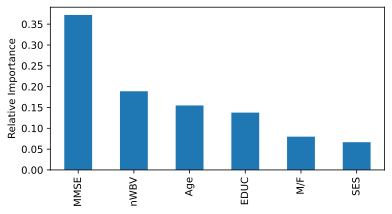

In [33]:
# feature importances:
feature_imp = pd.Series(rf_gs.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,3))
feature_imp.plot(kind='bar')
plt.ylabel('Relative Importance')
plt.show()

## Results - Model Comparison

In [34]:
# show performance metrics by model:
performance

,LR,KNN,SVM,RF
Accuracy,0.706667,0.666667,0.733333,0.733333
Precision,0.707317,0.652174,0.827586,0.771429
Recall,0.743590,0.769231,0.615385,0.692308
AUC,0.705128,0.662393,0.738248,0.735043


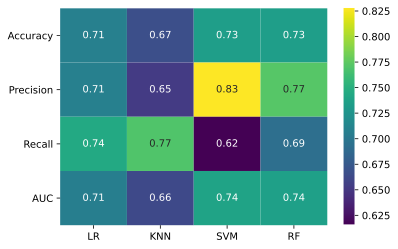

In [35]:
sns.heatmap(performance, annot=True, 
            cmap='viridis')
plt.yticks(rotation=0)
plt.show()

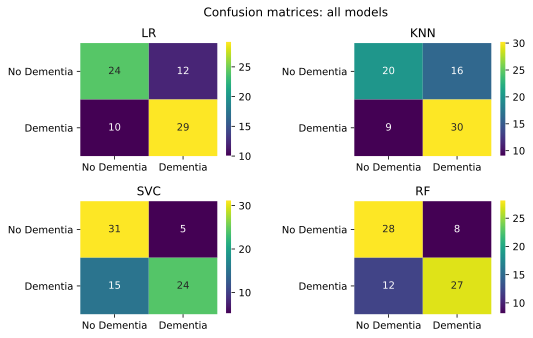

In [36]:
# plot confusion matrices:
fig=plt.figure(figsize=(8,5))
plt.suptitle('Confusion matrices: all models')

ax1=fig.add_subplot(2,2,1)
plt.title('LR')
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_lr), 
             index=["No Dementia", "Dementia"], 
             columns=["No Dementia", "Dementia"]), 
             annot=True, fmt='d', cmap='viridis', ax=ax1)

ax1=fig.add_subplot(2,2,2)
plt.title('KNN')
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_knn), 
             index=["No Dementia", "Dementia"], 
             columns=["No Dementia", "Dementia"]), 
             annot=True, fmt='d', cmap='viridis', ax=ax1)

ax1=fig.add_subplot(2,2,3)
plt.title('SVC')
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_svc), 
             index=["No Dementia", "Dementia"], 
             columns=["No Dementia", "Dementia"]), 
             annot=True, fmt='d', cmap='viridis', ax=ax1)

ax1=fig.add_subplot(2,2,4)
plt.title('RF')
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred_rf), 
             index=["No Dementia", "Dementia"], 
             columns=["No Dementia", "Dementia"]), 
             annot=True, fmt='d', cmap='viridis', ax=ax1)

plt.subplots_adjust(hspace=0.4,
                    wspace=0.6)
plt.show()

## Key Findings

The key finding from the above classification models are that: 

* MMSE is the most important feature by far for predicting dementia, following by normalized intracramial volume and age.  
* Both SVM and RF models have the highest accuracy and auc scores.   
* SVM and RF seems to trade-off precision and recall differently:  
    * SVM produces high precision, which means that the model does not falsely label nondemented people (0) has having dementia (1) very often.   
    * However, the SVM model has the worst recall (sensitivity), which means that it fails to identify people with dementia quite frequently. Despite being the worst-performing model overall, recall is actually where KNN does best.   
* I think, based on a balance of performance metrics, the RF model might be the best to use.  

## Problems and Future Directions

The above models could be potentially improved in a number of ways, by, for example, adding polynomial terms or trying non-linear SVM. One limitation was relatively few samples (only 150 people) and few features (6 ended up being used to predict dementia). More subjects and more information about those subjects is likely to improve model performance, for example, by including more specific information from brain strctures rather than just intracranial volume, and additional cognitive assessments could provide more sensitive indicators of cognitive decline. 